In [34]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [36]:
## Functions

def download_dataset():
  """This function downloads, unzips and saves the dataset to /tmp/flower_photos"""
  !curl http://download.tensorflow.org/example_images/flower_photos.tgz --output /tmp/flower_photos.tgz
  !tar -xvzf /tmp/flower_photos.tgz
  return


def get_datagenerators(base_dir = 'flower_photos', img_height = 150, img_width = 150, batch_size = 20):
  """This function takes as input a directory containing the dataset, and returns generators for train and validation"""  

  datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

  # Augmentation
  train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2) # set validation split)

  train_generator = train_datagen.flow_from_directory(
      base_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='sparse',
      subset='training') # set as training data

  validation_generator = train_datagen.flow_from_directory(
      base_dir, # same directory as training data
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='sparse',
      subset='validation') # set as validation data

  return train_generator, validation_generator

# Baseline model

In [37]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B

# Write your neural network here!
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
# x = layers.Conv2D(16, 3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
# x = layers.Conv2D(32, 3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu')(x)
# x = layers.Convolution2D(64, 3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)
# x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(x)

# TODO 1. Add a dropout layer with a dropout rate of 0.2
x = layers.Dropout(rate=0.5, seed=42)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(5, activation='softmax')(x)

In [38]:
# Configure and compile the model
model = Model(img_input, output, name='baseline')

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(lr=0.001),
            #   optimizer='adam',
              metrics=['acc'])

In [39]:
model.summary()

Model: "baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 64)        0  

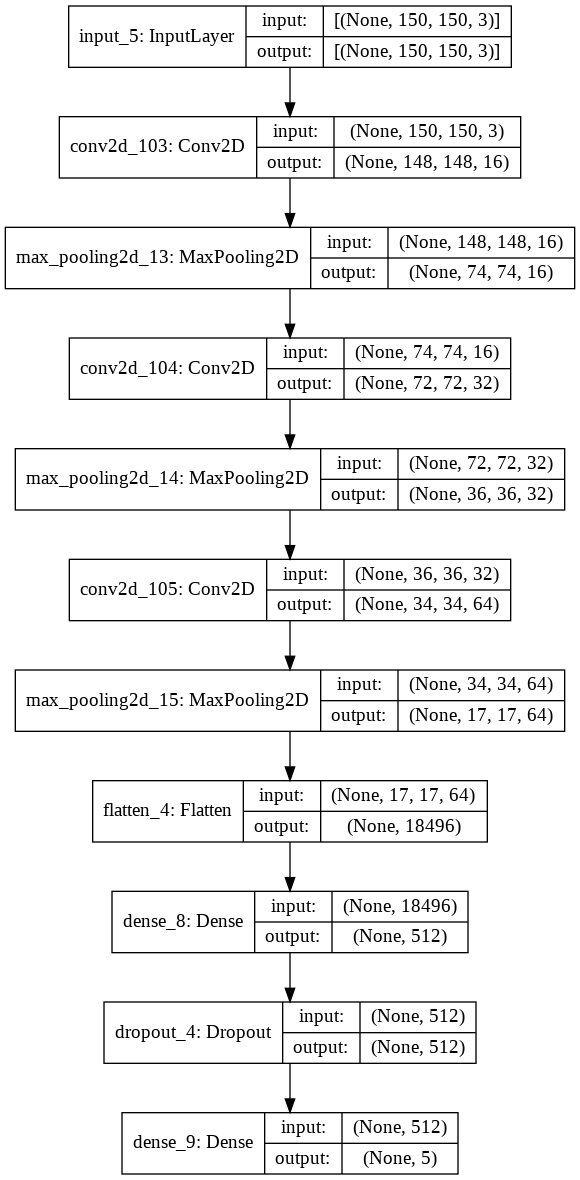

In [40]:
# NN model plot
tf.keras.utils.plot_model(model, to_file='baseline_structure.png', show_shapes=True, show_layer_names=True)

In [41]:
# adding callbacks -> earlystopping
my_callbacks = [
                tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]


In [42]:
#download_dataset()

#fit the model
model_name = 'M1'
nb_epochs = 10
batch_size = 20
train_generator, validation_generator = get_datagenerators(batch_size=batch_size)

history = model.fit(
    train_generator,
    epochs = 100,
    validation_data=validation_generator,
    callbacks=my_callbacks)

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
Epoch 1/100
147/147 [==============================] - 27s 179ms/step - loss: 47.3852 - acc: 0.2572 - val_loss: 1.6106 - val_acc: 0.2558
Epoch 2/100
147/147 [==============================] - 26s 179ms/step - loss: 1.6346 - acc: 0.2272 - val_loss: 1.5793 - val_acc: 0.2818
Epoch 3/100
147/147 [==============================] - 26s 178ms/step - loss: 1.9070 - acc: 0.2608 - val_loss: 1.7753 - val_acc: 0.2490
Epoch 4/100
147/147 [==============================] - 26s 178ms/step - loss: 1.6879 - acc: 0.2672 - val_loss: 1.5777 - val_acc: 0.2681
Epoch 5/100
147/147 [==============================] - 26s 179ms/step - loss: 1.6072 - acc: 0.2773 - val_loss: 1.5635 - val_acc: 0.2668
Epoch 6/100
147/147 [==============================] - 26s 178ms/step - loss: 1.6027 - acc: 0.2723 - val_loss: 1.5197 - val_acc: 0.3078
Epoch 7/100
147/147 [==============================] - 26s 178ms/step - loss: 1.6104 - acc: 0.2954 -

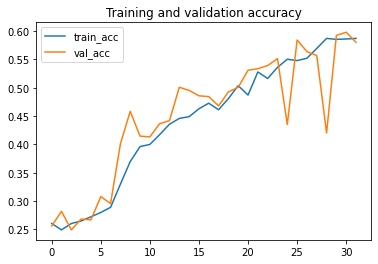

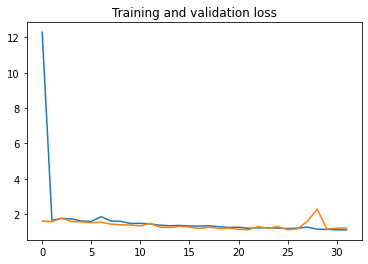

In [43]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = 'train_acc')
plt.plot(epochs, val_acc, label = 'val_acc')
plt.title('Training and validation accuracy')

# save fig
plt.legend()
plt.savefig(f'{model_name} baseline_accuracy')
plt.figure()


# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

# save fig
plt.savefig(f'{model_name} baseline_loss')

# M1 model

In [44]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B

# Write your neural network here!
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
# x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.Conv2D(16, 3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
# x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(32, 3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
# x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.Convolution2D(64, 3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
# x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)

# TODO 1. Add a dropout layer with a dropout rate of 0.2
x = layers.Dropout(rate=0.5, seed=42)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(5, activation='softmax')(x)

In [45]:
# Configure and compile the model
model_1 = Model(img_input, output, name='M1')

model_1.compile(loss='sparse_categorical_crossentropy',
            #   optimizer=RMSprop(lr=0.001),
              optimizer='adam',
              metrics=['acc'])

In [46]:
model_1.summary()

Model: "M1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 17, 17, 64)        0        

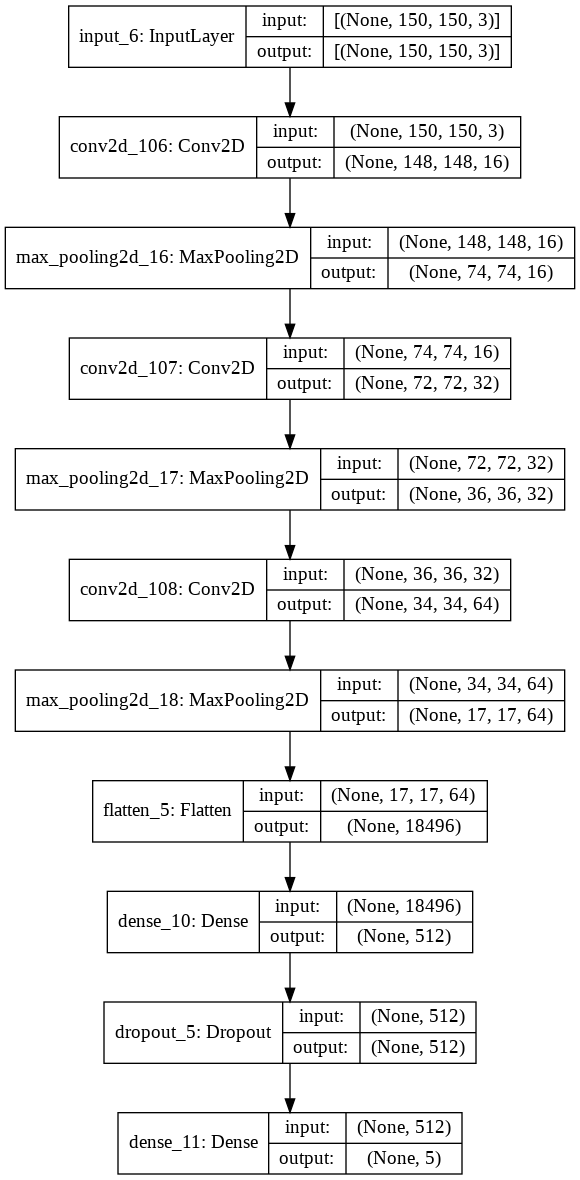

In [47]:
# NN model plot
tf.keras.utils.plot_model(model_1, to_file='M1_structure.png', show_shapes=True, show_layer_names=True)

In [48]:
#fit the model
model_name = 'M1'
nb_epochs = 10
batch_size = 20
train_generator, validation_generator = get_datagenerators(batch_size=batch_size)

history = model.fit(
    train_generator,
    epochs = 100,
    validation_data=validation_generator,
    callbacks=my_callbacks)

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
Epoch 1/100
147/147 [==============================] - 27s 182ms/step - loss: 1.2579 - acc: 0.5165 - val_loss: 1.2736 - val_acc: 0.5759
Epoch 2/100
147/147 [==============================] - 26s 180ms/step - loss: 1.1939 - acc: 0.5427 - val_loss: 1.2611 - val_acc: 0.5513
Epoch 3/100
147/147 [==============================] - 26s 179ms/step - loss: 1.2117 - acc: 0.5155 - val_loss: 1.2498 - val_acc: 0.5445
Epoch 4/100
147/147 [==============================] - 27s 181ms/step - loss: 1.1795 - acc: 0.5390 - val_loss: 1.1735 - val_acc: 0.5910
Epoch 5/100
147/147 [==============================] - 26s 179ms/step - loss: 1.1857 - acc: 0.5400 - val_loss: 1.3233 - val_acc: 0.4829
Epoch 6/100
147/147 [==============================] - 26s 179ms/step - loss: 1.1682 - acc: 0.5594 - val_loss: 1.3702 - val_acc: 0.5363
Epoch 7/100
147/147 [==============================] - 27s 181ms/step - loss: 1.1773 - acc: 0.5478 - 

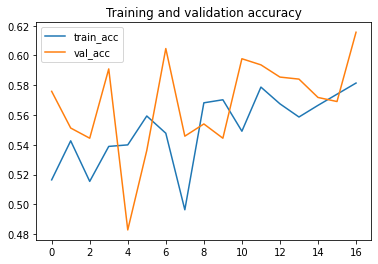

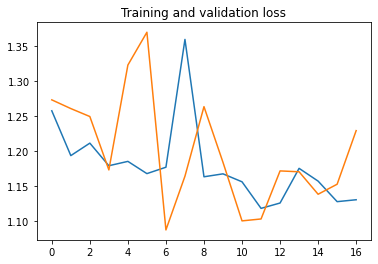

In [49]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = 'train_acc')
plt.plot(epochs, val_acc, label = 'val_acc')
plt.title('Training and validation accuracy')

# save fig
plt.savefig('M2_accuracy')

plt.legend()
plt.figure()


# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

# save fig
plt.savefig('M2_loss')

# **[TODO] IMPROVE THE MODEL BY USING INCEPTION V3**

In [50]:
# getting the weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


--2021-05-02 00:51:18--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.80, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   156MB/s    in 0.5s    

2021-05-02 00:51:18 (156 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [51]:
# import inceptionV3
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

In [52]:
# fix layers -> make them not trainable
for layer in pre_trained_model.layers:
  layer.trainable = False

In [53]:
# using feature extraction
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


# M2 model

In [54]:
# connect the last output
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.5, seed=42)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(5, activation='softmax')(x)


In [55]:
# Configure and compile the model
model_2 = Model(pre_trained_model.input, x, name='M2')

model_2.compile(loss='sparse_categorical_crossentropy',
                # optimizer=RMSprop(lr=0.001),
                optimizer='adam',
                metrics=['acc'])

In [56]:
model_2.summary()

Model: "M2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_109 (Conv2D)             (None, 74, 74, 32)   864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_109[0][0]                 
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_________________________________________________________________________________________________

In [57]:
# NN model plot
tf.keras.utils.plot_model(model_2, to_file='M2_structure.png', show_shapes=True, show_layer_names=True)

In [58]:
#fit the model
model_name = 'M3'
nb_epochs = 10
batch_size = 20
train_generator, validation_generator = get_datagenerators(batch_size=batch_size)

history = model.fit(
    train_generator,
    epochs = 100,
    validation_data=validation_generator,
    callbacks=my_callbacks)

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
Epoch 1/100
147/147 [==============================] - 27s 181ms/step - loss: 1.1699 - acc: 0.5577 - val_loss: 1.2082 - val_acc: 0.6074
Epoch 2/100
147/147 [==============================] - 26s 179ms/step - loss: 1.1498 - acc: 0.5730 - val_loss: 1.1457 - val_acc: 0.5746
Epoch 3/100
147/147 [==============================] - 26s 180ms/step - loss: 1.1181 - acc: 0.5781 - val_loss: 1.1942 - val_acc: 0.5910
Epoch 4/100
147/147 [==============================] - 26s 178ms/step - loss: 1.0914 - acc: 0.5910 - val_loss: 1.1295 - val_acc: 0.6005
Epoch 5/100
147/147 [==============================] - 26s 179ms/step - loss: 1.1213 - acc: 0.5863 - val_loss: 1.0508 - val_acc: 0.5636
Epoch 6/100
147/147 [==============================] - 26s 178ms/step - loss: 1.0814 - acc: 0.5818 - val_loss: 1.0739 - val_acc: 0.5869
Epoch 7/100
147/147 [==============================] - 26s 177ms/step - loss: 1.1183 - acc: 0.5910 - 

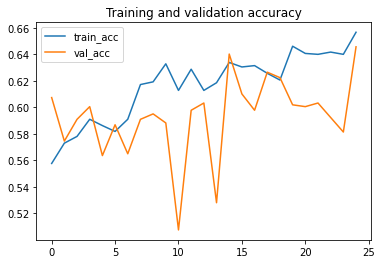

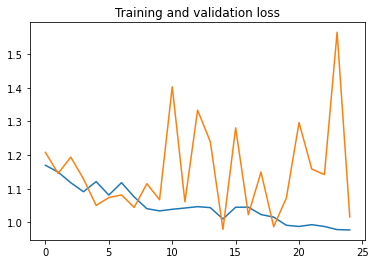

In [59]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = 'train_acc')
plt.plot(epochs, val_acc, label = 'val_acc')
plt.title('Training and validation accuracy')

# save fig
plt.savefig('M3_accuracy')

plt.legend()
plt.figure()


# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

# save fig
plt.savefig('M3_loss')